In [171]:
%load_ext autoreload

%autoreload 2

from glob import glob
from os.path import join
import os
import pickle

import scipy.linalg
import matplotlib
matplotlib.rcParams["figure.dpi"] = 144
matplotlib.rcParams["savefig.dpi"] = 144
import matplotlib.pyplot as plt
import numpy as np

from astropy.table import Table, Column
import astropy.units as U

import emcee

import kepler
import threebody

import minuit_wrap
%matplotlib inline

import logging


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [172]:
#d = pickle.load(open("forecaster_params.pickle"))
#d["files"] = "tuned_mueller_pulses_selected"
#d["toa_mode"] = "pipeline"
#d = pickle.load(open("fitter_params.pickle"))
d = pickle.load(open("downhill-runs/lband/fitter_params.pickle"))
F = threebody.Fitter(**d)

d

{'dmx_span': 182.62125,
 'efac': 1,
 'fdn_range': (1, 5),
 'files': 'tuned2_aligned_pulses_1400_nosun2',
 'fit_pm': True,
 'fit_pos': True,
 'fit_px': True,
 'kopeikin': False,
 'linear_dm': False,
 'linear_jumps': True,
 'parfile': '0337_de430.par',
 'ppn_mode': 'heavysimple',
 'priors': ('dbeta', 'dgamma'),
 't2_astrometry': True,
 'toa_mode': 'pipeline',
 'tzrmjd_middle': 'auto',
 'variable_dm': True,
 'variable_ipm': True}

/users/aarchiba/.virtualenvs/triplesystem/lib/python2.7/site-packages/scipy/optimize/zeros.py:173: RuntimeWarning: Tolerance of -1.08420217249e-19 reached
  warnings.warn(msg, RuntimeWarning)


35963.574013696456273

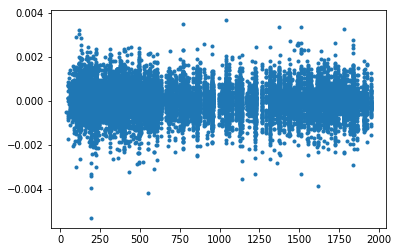

In [173]:
res = F.residuals(F.best_parameters)
plt.plot(F.mjds, res,".")
F.goodness_of_fit()

In [174]:
toa_infos = F.annotated_toas(residuals=F.residuals())

In [175]:
t = toa_infos[0]
print t["flags"]["resid_phase"], t["flags"]["uncert_phase"]
print t["flags"]["resid_phase"]/t["flags"]["uncert_phase"]
print F.residuals()[0], F.uncerts[0]
print 1e-6*t["uncert"]*F.reference_f0

-0.000525951385498 0.00080370190105
-0.654411025793
-0.000525951385498 2.19618664464e-06
0.00080370190105


In [176]:
zs = [np.abs(t["flags"]["resid_phase"]/t["flags"]["uncert_phase"])
      for t in toa_infos]
ix = np.argsort(zs)[::-1]
i = 0
files = {}
z = np.inf
while(z)>10:
    t = toa_infos[ix[i]]
    f = t["file"]
    o = f.split("/")[2]
    if o not in files:
        z = zs[ix[i]]
        files[o] = [z,
                    1e6*t["flags"]["resid_s"], 
                    t["uncert"], 
                    0]
    files[o][3] += 1        
    i += 1
    
os = []
zss = []
rs = []
us = []
ns = []
for k, v in sorted(files.items()):
    os.append(k)
    zss.append(v[0])
    rs.append(v[1])
    us.append(v[2])
    ns.append(v[3])
    
rows = [[k, v[0], v[1], v[2], v[3]] for (k,v) in sorted(files.items())]
rows.sort(key=lambda r: -r[1])
T = Table(rows=rows,
          names=["Observation", "abs(z)", 
                 "residual", "uncertainty", "n"])
T['residual'].unit = U.us
T['uncertainty'].unit = U.us
T['abs(z)'].format = ".2f"
T['residual'].format = ".3f"
T['uncertainty'].format = ".3f"
T.pprint(max_lines=-1)
bad_observations = os[:]

  Observation    abs(z) residual uncertainty  n 
                           us         us        
---------------- ------ -------- ----------- ---
56554.34_AO_1400   9.04   -4.338       0.480   1


In [177]:
def plot_observation(o):
    ts = [t for t in toa_infos if o in t["file"].split("/")]
    mjds = np.array([t["mjd"] for t in ts])
    freqs = np.array([t["freq"] for t in ts])
    res = np.array([t["flags"]["resid_s"] for t in ts])
    unc = np.array([t["uncert"]*1e-6 for t in ts])
    t = (mjds-mjds[0])*86400
    
    plt.figure()
    plt.subplot(121)
    plt.title(o)
    plt.axhline(0, color="orange")
    plt.errorbar(t, 1e6*res, 1e6*unc, linestyle="none", marker=".")
    plt.xlabel("t (s)")
    plt.ylabel("residual ($\mu$s)")
    n,x = plt.ylim()
    plt.subplot(122)
    plt.axhline(0, color="orange")
    plt.errorbar(freqs, 1e6*res, 1e6*unc, linestyle="none", marker=".")
    plt.xlabel("f (MHz)")
    plt.ylim(n,x)
    plt.gca().yaxis.set_ticklabels([])
    plt.subplots_adjust(wspace=0)
    plt.savefig("outlier-plots/%s.pdf" % o)

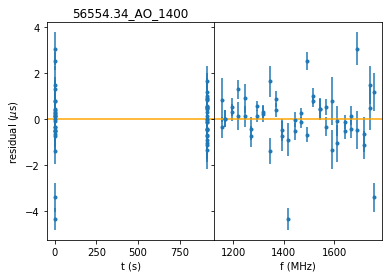

In [178]:
for o in bad_observations:
    plot_observation(o)

## Grouped residuals

In [179]:
groups = {}
for t in toa_infos:
    f = t["file"]
    if f not in groups:
        groups[f] = []
    groups[f].append(t)

In [180]:
def combine(values, uncerts):
    weights = 1/uncerts
    sw = np.sum(weights)
    v = np.sum(weights*values)/sw
    u = np.sqrt(np.sum((weights*uncerts)**2))/sw
    return v,u

In [181]:
tels = set()
avgs = []
for k in sorted(groups.keys()):
    ts = groups[k]
    r = np.array([1e6*t["flags"]["resid_s"] for t in ts])
    u = np.array([t["uncert"] for t in ts])
    m = np.array([t["mjd"] for t in ts])
    ipms = np.array([float(t["flags"]["ipm"]) for t in ts])
    ar, au = combine(r,u)
    am, _ = combine(m,u)
    ipm, _ = combine(ipms,u)
    tels.add(t["tel"])
    if au<0.5:
        avgs.append(dict(key=k,mjd=am,res=ar,uncert=au, 
                         ipm=ipm,tel=t["tel"]))

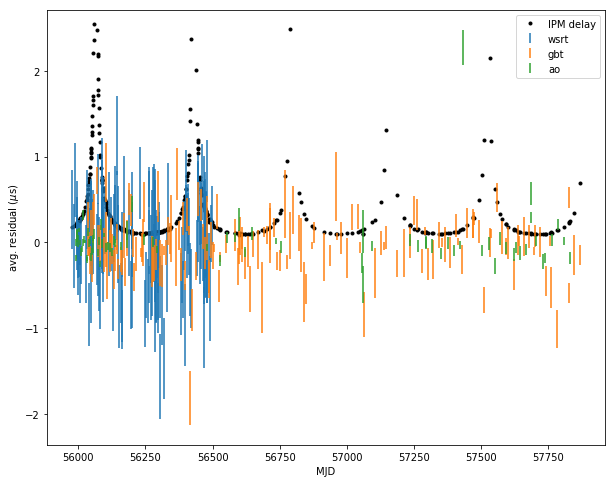

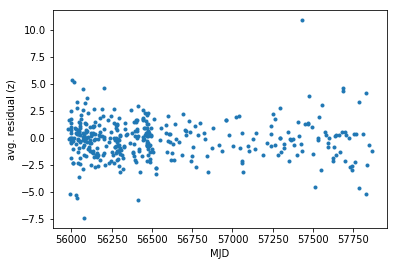

In [182]:
for t in sorted(tels)[::-1]:
    plt.errorbar([a["mjd"] for a in avgs if a["tel"]==t], 
               [a["res"] for a in avgs if a["tel"]==t],
               [a["uncert"] for a in avgs if a["tel"]==t],
                  label=t,
                linestyle="none")
yl,yh = plt.ylim()
plt.plot([a["mjd"] for a in avgs],
         [1e6*a["ipm"] for a in avgs],
        "k.", zorder=-5, label="IPM delay")
plt.ylim(yl,yh)
plt.legend()
plt.xlabel("MJD")
plt.ylabel("avg. residual ($\mu$s)")
plt.gcf().set_size_inches(10,8)
plt.savefig("per-obs.pdf")
plt.figure()
plt.plot([a["mjd"] for a in avgs], 
           [a["res"]/a["uncert"] for a in avgs],
        ".")
plt.xlabel("MJD")
plt.ylabel("avg. residual (z)")



In [183]:
for a in avgs:
    if a["mjd"]<57250:
        continue
    k = a["key"].split("/")[2]
    print k, threebody.fmt(a["res"], a["uncert"]), a["res"]/a["uncert"]

57262.25_GBT_1400 3.3(18)e-1 1.79807032685
57263.39_AO_1400 -4(7)e-2 -0.627986446515
57280.44_GBT_1400 -2.1(14)e-1 -1.54541830291
57292.43_GBT_1400 1.3(5)e-1 2.79589856497
57293.30_AO_1400 0(7)e-2 -0.0149379658187
57293.32_AO_1400 0(7)e-2 -0.0228203740416
57301.32_GBT_1400 -2.5(19)e-1 -1.32067349878
57317.25_AO_1400 -4(8)e-2 -0.505222832417
57322.45_GBT_1400 -2(2)e-1 -0.873309917227
57343.12_GBT_1400 0(16)e-2 0.55790590266
57349.14_AO_1400 -1.3(6)e-1 -2.10795604683
57354.24_GBT_1400 0(5)e-2 -0.0391298096654
57364.04_GBT_1400 0(2)e-1 -0.133228577045
57376.08_AO_1400 0(7)e-2 -0.117690126214
57384.08_GBT_1400 -1.2(18)e-1 -0.668852575776
57400.02_AO_1400 -9(6)e-2 -1.57097238348
57405.23_GBT_1400 2.0(14)e-1 1.45579652727
57413.11_GBT_1400 0(4)e-2 0.185345642541
57422.95_AO_1400 -3(5)e-2 -0.570540801475
57428.86_GBT_1400 -2.0(17)e-1 -1.1935240525
57431.99_AO_1400 2.3(2)e0 10.9187467454
57448.92_GBT_1400 2.3(18)e-1 1.31621109616
57470.88_GBT_1400 2.2(17)e-1 1.29000402021
57471.79_GBT_1400 1.8

In [184]:
toa_infos[0]

{'file': 'data/obs/55956.70_WSRT_1400/tuned2/scrunch_0000.ar',
 'flags': {'P': '0.00273285578456',
  'band': '1400',
  'bw': '20.0',
  'chan': '5',
  'day_bary': 36.698945946259331999,
  'ipm': '1.37889118459e-07',
  'max_smearing': '0.04241883288',
  'mode': 'fold',
  'nbin': '512',
  'phase': '0.30476971276',
  'pn': '-4530974479',
  'processing_name': 'tuned2',
  'reduced_chi2': '1.10940790474',
  'resid_phase': -0.000525951385498046875,
  'resid_s': -1.4372087549522615235e-06,
  'snr': '11.1171428287',
  'solarangle': '105.804707157',
  'subint': '0',
  'tel': 'WSRT',
  'toa_name': 'aligned',
  'tsubint': '579.996288',
  'uncert': '0.000803623322186',
  'uncert_phase': 0.00080370190104991543,
  'uncert_scaled': '0.000846443861987',
  'weighted_frequency': '1429.375'},
 'freq': 1409.375,
 'mjd': 55956.696412057274,
 'mjd_string': '55956.69641205727328014952',
 'tel': 'wsrt',
 'uncert': 2.19618664464}